In [124]:
import pandas as pd
import psycopg2
import sqlalchemy
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.stats import gaussian_kde
from mpl_toolkits import mplot3d
import random
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
pio.renderers.default = "vscode"
from scipy.spatial import distance
import statsmodels.api as sm

conn_url = sqlalchemy.engine.URL.create(
    drivername='postgresql+psycopg2',
    username='jericho',
    password='Ilikesony1!',
    host='holocron.local',
    database='postgres'
)

eng = create_engine(conn_url)

#### Uploading stringency datasets

In [2]:
# import os

# path = '/Users/jericho/Documents/csi/csi-research/Notebooks/MKL_2_notebooks/data/'

# files = os.listdir(path)
# files = [i for i in files if i[-3:]== 'csv']
# files = [i for i in files if 'Case_Surveillance' not in i]

# files

# for f in files:
#     try:
#         df = pd.read_csv(path+f)
#         df.to_sql(f[:-4], con=eng, schema='cdsdata')
#     except:
#         print(f'failed to upload {f}')

# # files = ['f_phi_lam_export.csv']

# # for i in files:
# #     dataset = i
# #     df = pd.read_csv(path+dataset)
# #     df.to_sql(dataset[:-4], con=eng, schema='cdsdata', index=False)

## Downloading DB Data

In [3]:
eng = create_engine(conn_url)
df = pd.read_sql_query('SELECT * FROM postgres.cdsdata.f_phi_lam_export', con=eng)
df = df[[i for i in df.columns.tolist()[1:]]]
display(df.head())

GTCBSA   LOG_POP  NEW_WEIGHT  count  ALL_nh_fam         w  const  \
0   30340  5.031820    291237.0     13    0.395242  0.000411      1   
1   48700  5.058160    352900.0     26    0.309311  0.000821      1   
2   17420  5.088359    372751.0     23    0.454698  0.000726      1   
3   24020  5.099998    386534.0     33    0.373157  0.001042      1   
4   43300  5.117318    373973.0     21    0.298623  0.000663      1   

   count_pew     phi_D     w_pew      wlam    lambda         t      t_w  
0          3  0.678888  0.001758  0.000551  0.582190  1.849351  0.00065  
1          1  1.000000  0.000586  0.002272  0.309311  3.054868  0.00078  
2          2  0.610938  0.001172  0.000629  0.744262  6.348615  0.00117  
3          2  0.465040  0.001172  0.000445  0.802421  3.298420  0.00169  
4          1  1.000000  0.000586  0.001892  0.298623  2.915356  0.00091

### Verifying Downloaded variables

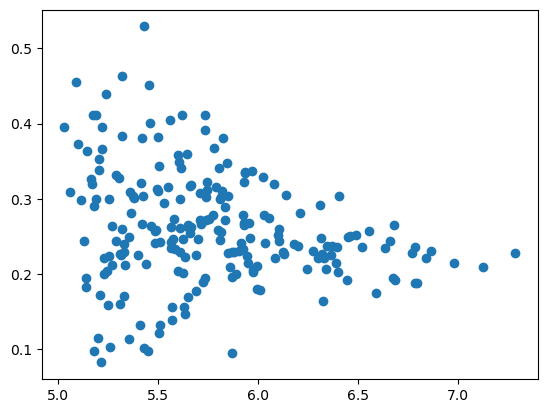

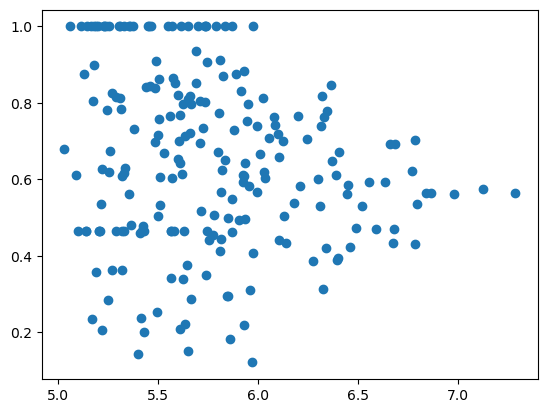

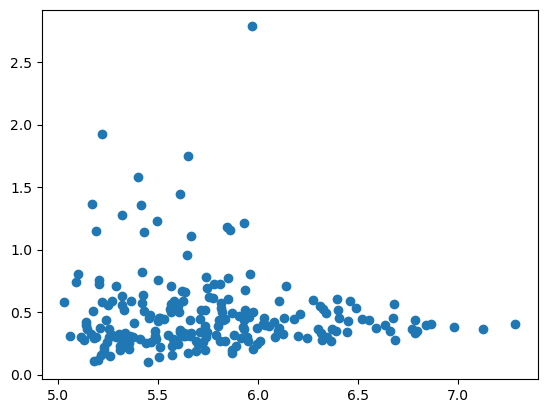

In [4]:
plt.scatter(df['LOG_POP'], df['ALL_nh_fam'])
plt.show()
plt.scatter(df['LOG_POP'], df['phi_D'])
plt.show()
plt.scatter(df['LOG_POP'], df['lambda'])
plt.show()

In [5]:
eng = create_engine(conn_url)
df_trips = pd.read_sql_query('SELECT * FROM postgres.cdsdata."cbsa_data_(k,M,f,h,s,p).csv"', con=eng)
df_trips = df_trips[[i for i in df_trips.columns.tolist()[2:]]]
display(df_trips.head())

GTCBSA  ALL_fpll  SOCIAL_fpll  CARE_fpll  K1_deaths  K2_deaths  K3_deaths  \
0   10100  0.000000     0.000000   0.000000   0.000000   0.000000   0.071113   
1   10140  0.000000     0.000000   0.000000   0.000000   0.123776   0.037184   
2   10180  0.231019     0.212377   0.048661   0.067069   0.014818   0.000000   
3   10220  0.000000     0.000000   0.000000   0.099021   0.057924   0.054147   
4   10300  0.000000     0.000000   0.000000   0.123776   0.073980   0.063128   

   K1_cases  K2_cases  K3_cases  ...  percent_traveling_2020_w3  \
0  0.204861  0.027668  0.021953  ...                   0.779609   
1  0.214707  0.043326  0.000000  ...                   0.713209   
2  0.414097  0.020414  0.130096  ...                   0.722977   
3  0.171522  0.046909  0.002207  ...                   0.769726   
4  0.257475  0.020088  0.029262  ...                   0.751883   

   trips_per_traveler_2020_w3  trips_<25_per_traveler_2020_w3  \
0                    4.209785                        3.777861   
1                    3.574591                        2.990611   
2                    3.717278                        3.437942   
3                    4.080710                        3.716047   
4                    4.125796                        3.602889   

   community_wfh_score  percent_travel_ratio_w2  percent_travel_ratio_w3  \
0                  NaN                 0.990991                 0.974131   
1                  NaN                 0.932799                 0.917500   
2             2.918824                 0.960496                 0.931751   
3                  NaN                 0.966060                 0.945872   
4                  NaN                 0.974241                 0.937457   

   trips_per_traveler_ratio_w2  trips_per_traveler_ratio_w3  \
0                     0.973858                     0.973035   
1                     0.714438                     0.572800   
2                     0.831695                     0.914361   
3                     1.016260                     1.046986   
4                     0.776336                     0.874302   

   trips_<25_per_traveler_ratio_w2  trips_<25_per_traveler_ratio_w3  
0                         0.979169                         0.967053  
1                         0.692102                         0.531357  
2                         0.816526                         0.905197  
3                         0.993065                         1.022204  
4                         0.778010                         0.866049  

[5 rows x 53 columns]

## String lists of variables

In [6]:
df_stringency = df_trips[['GTCBSA','CBSA_c2_workplace_closing',
       'CBSA_c4_restrictions_on_gatherings',
       'CBSA_c6_stay_at_home_requirements', 'CBSA_h6_facial_coverings',
       'CBSA_c1_school_closing', 'CBSA_c3_cancel_public_events',
       'CBSA_c7_movementrestrictions', 'CBSA_c5_close_public_transport',]].copy()

df_travel = df_trips[['GTCBSA', 'stayed_home_wave2', 'stayed_home_wave3', 'tiles_visited_wave2',
       'tiles_visited_wave3','percent_travel_ratio_w2', 'percent_travel_ratio_w3',
       'trips_per_traveler_ratio_w2', 'trips_per_traveler_ratio_w3',
       'trips_<25_per_traveler_ratio_w2', 'trips_<25_per_traveler_ratio_w3']]


## Z Score Calculations

In [7]:
df_metrics = df.merge(df_stringency, on='GTCBSA', how='inner')
df_metrics = df_metrics.merge(df_travel, on='GTCBSA', how='inner')
df_metrics.columns

metrics = ['ALL_nh_fam','phi_D','lambda','t', 'w']
stringency = [ 'CBSA_c2_workplace_closing', 'CBSA_c4_restrictions_on_gatherings',
       'CBSA_c6_stay_at_home_requirements', 'CBSA_h6_facial_coverings',
       'CBSA_c1_school_closing', 'CBSA_c3_cancel_public_events',
       'CBSA_c7_movementrestrictions', 'CBSA_c5_close_public_transport']
travel = ['stayed_home_wave2', 'stayed_home_wave3', 'tiles_visited_wave2',
       'tiles_visited_wave3','percent_travel_ratio_w2', 'percent_travel_ratio_w3',
       'trips_per_traveler_ratio_w2', 'trips_per_traveler_ratio_w3',
       'trips_<25_per_traveler_ratio_w2', 'trips_<25_per_traveler_ratio_w3']

df_metrics_z = df_metrics.copy()

for col in stringency:
    if col == 'CBSA_h6_facial_coverings':
        df_metrics_z[col] = 0
    else:
        df_metrics_z[col] = (df_metrics_z[col]-df_metrics_z[col].mean()) /  df_metrics_z[col].std()

for col in travel:
    df_metrics_z[col] = (df_metrics_z[col]-df_metrics_z[col].mean()) /  df_metrics_z[col].std()

In [144]:
df_metrics_z.columns

Index(['GTCBSA', 'LOG_POP', 'NEW_WEIGHT', 'count', 'ALL_nh_fam', 'w', 'const',
       'count_pew', 'phi_D', 'w_pew', 'wlam', 'lambda', 't', 't_w',
       'CBSA_c2_workplace_closing', 'CBSA_c4_restrictions_on_gatherings',
       'CBSA_c6_stay_at_home_requirements', 'CBSA_h6_facial_coverings',
       'CBSA_c1_school_closing', 'CBSA_c3_cancel_public_events',
       'CBSA_c7_movementrestrictions', 'CBSA_c5_close_public_transport',
       'stayed_home_wave2', 'stayed_home_wave3', 'tiles_visited_wave2',
       'tiles_visited_wave3', 'percent_travel_ratio_w2',
       'percent_travel_ratio_w3', 'trips_per_traveler_ratio_w2',
       'trips_per_traveler_ratio_w3', 'trips_<25_per_traveler_ratio_w2',
       'trips_<25_per_traveler_ratio_w3', 'str_z_mahal', 'str_z_sum',
       'mob_z_mahal', 'mob_z_sum', 'str_z_direc', 'str_z_mahal_tran',
       'mob_z_direc', 'mob_z_mahal_tran'],
      dtype='object')

## Mahalanobis Distances

In [8]:
def mahal_vector(df):
    # Calc col means
    means = df.mean()

    # Calc covariance matrix & inv
    cov_matrix = df.cov()
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    # center the dataframe
    df_sub = df - means

    #calc mahal dist
    mahal = []
    for i in range(len(df)):
        mahal.append(distance.mahalanobis(df_sub.iloc[i], np.zeros(df_sub.shape[1]), inv_cov_matrix))
    
    return mahal


strings = ['CBSA_c7_movementrestrictions','CBSA_c6_stay_at_home_requirements','CBSA_c4_restrictions_on_gatherings']
travel_strings = ['tiles_visited_wave2', 'tiles_visited_wave3','percent_travel_ratio_w2', 
                  'percent_travel_ratio_w3', 'trips_per_traveler_ratio_w2', 'trips_per_traveler_ratio_w3', 
                  'trips_<25_per_traveler_ratio_w2', 'trips_<25_per_traveler_ratio_w3']

df_metrics_z['str_z_mahal'] = mahal_vector(df_metrics_z[strings])
df_metrics_z['str_z_sum'] = df_metrics_z[strings].sum(axis=1)
df_metrics_z['mob_z_mahal'] = mahal_vector(df_metrics_z[travel_strings])
df_metrics_z['mob_z_sum'] = df_metrics_z[travel_strings].sum(axis=1)

df_metrics_z

GTCBSA   LOG_POP  NEW_WEIGHT  count  ALL_nh_fam         w  const  \
0     30340  5.031820    291237.0     13    0.395242  0.000411      1   
1     48700  5.058160    352900.0     26    0.309311  0.000821      1   
2     17420  5.088359    372751.0     23    0.454698  0.000726      1   
3     24020  5.099998    386534.0     33    0.373157  0.001042      1   
4     43300  5.117318    373973.0     21    0.298623  0.000663      1   
..      ...       ...         ...    ...         ...       ...    ...   
210   26420  6.837850  21380791.0    734    0.221629  0.023182      1   
211   19100  6.864550  23200676.0    797    0.230942  0.025171      1   
212   16980  6.978117  30865388.0   1162    0.214055  0.036699      1   
213   31080  7.122203  43636881.0   1198    0.209286  0.037836      1   
214   35620  7.285428  63855127.0   2033    0.227741  0.064207      1   

     count_pew     phi_D     w_pew  ...  percent_travel_ratio_w2  \
0            3  0.678888  0.001758  ...                 1.114525   
1            1  1.000000  0.000586  ...                 2.241914   
2            2  0.610938  0.001172  ...                 1.211712   
3            2  0.465040  0.001172  ...                 1.415057   
4            1  1.000000  0.000586  ...                 0.304148   
..         ...       ...       ...  ...                      ...   
210         23  0.564054  0.013482  ...                 0.057856   
211         35  0.565222  0.020516  ...                -0.155396   
212         59  0.562552  0.034584  ...                 0.263320   
213         57  0.574167  0.033411  ...                -2.477148   
214        113  0.564764  0.066237  ...                -1.918429   

     percent_travel_ratio_w3  trips_per_traveler_ratio_w2  \
0                   0.987797                     1.440025   
1                   1.493536                    -0.039059   
2                   1.149870                     0.666102   
3                   0.708146                     0.120638   
4                   0.661280                     0.977830   
..                       ...                          ...   
210                 0.580127                    -0.090923   
211                -0.015358                     0.070180   
212                -0.287005                    -0.075709   
213                -2.742984                    -2.018152   
214                -1.922590                    -0.233006   

     trips_per_traveler_ratio_w3  trips_<25_per_traveler_ratio_w2  \
0                       0.305287                         1.710714   
1                      -0.701464                         0.003996   
2                       0.615730                         0.599995   
3                      -0.052492                         0.260405   
4                       1.871012                         0.997801   
..                           ...                              ...   
210                     0.669811                        -0.042731   
211                     0.714238                         0.077050   
212                     0.271040                        -0.049226   
213                    -1.225133                        -1.963571   
214                     0.050810                        -0.146853   

     trips_<25_per_traveler_ratio_w3  str_z_mahal  str_z_sum  mob_z_mahal  \
0                           0.613116     3.510161   3.196423     4.990788   
1                          -0.683223     0.469840   0.298509     4.057189   
2                           0.562675     0.866147  -1.191175     2.107217   
3                           0.011432     2.557665   3.005005     3.856589   
4                           1.878038     0.787118  -0.105674     2.942902   
..                               ...          ...        ...          ...   
210                         0.703277     0.787118  -0.105674     2.377734   
211                         0.715452     0.787118  -0.105674     1.642638   
212                         0.256336     2.888121   4.11

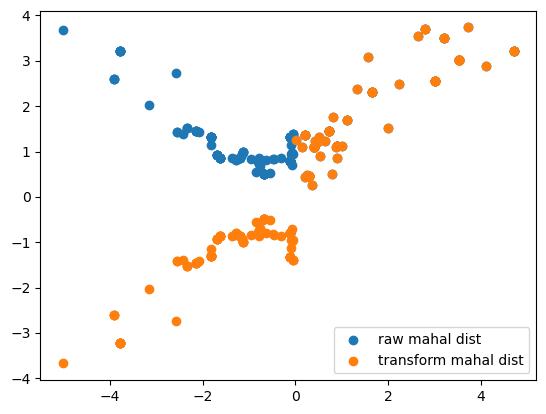

In [9]:
df_metrics_z['str_z_direc'] = df_metrics_z['str_z_sum'].apply(lambda x: x/abs(x))
df_metrics_z['str_z_mahal_tran'] = df_metrics_z['str_z_mahal'] * df_metrics_z['str_z_direc']

plt.scatter(df_metrics_z['str_z_sum'], df_metrics_z['str_z_mahal'], label='raw mahal dist')
plt.scatter(df_metrics_z['str_z_sum'], df_metrics_z['str_z_mahal_tran'], label='transform mahal dist')
plt.legend()

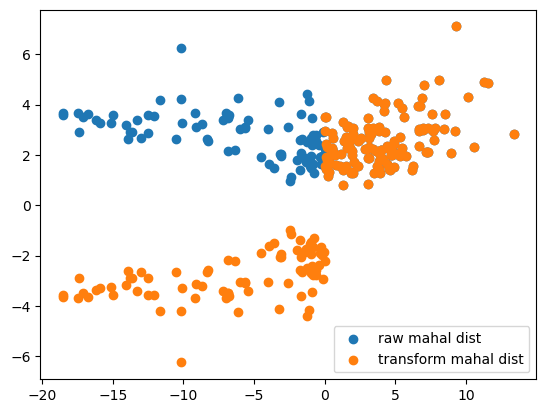

In [10]:
df_metrics_z['mob_z_direc'] = df_metrics_z['mob_z_sum'].apply(lambda x: x/abs(x))
df_metrics_z['mob_z_mahal_tran'] = df_metrics_z['mob_z_mahal'] * df_metrics_z['mob_z_direc']

plt.scatter(df_metrics_z['mob_z_sum'], df_metrics_z['mob_z_mahal'], label='raw mahal dist')
plt.scatter(df_metrics_z['mob_z_sum'], df_metrics_z['mob_z_mahal_tran'], label='transform mahal dist')
plt.legend()

## Parallel Coordinates

In [11]:
# m = []
# df_metrics_z[col]
# strings = ['CBSA_c7_movementrestrictions',
#     'CBSA_c6_stay_at_home_requirements',
#     'CBSA_c4_restrictions_on_gatherings']

# #df_metrics_z['str_z_sum'] = df_metrics_z[strings].sum(axis=1)
# df_metrics_z['str_avg'] = df_metrics_z[strings].mean(axis=1)

# #df_metrics_z['mob_z_sum'] = df_metrics_z[travel].sum(axis=1)
# df_metrics_z['mob_avg'] = df_metrics_z[travel].mean(axis=1)


# plt.figure(figsize=(6,4))
# for idx, row in df_metrics_z.iterrows():
#     measures = row[strings]
#     ex = sum(measures)/len(measures)
#     m.append(ex)
#     if ex > 0.25: 
#         color = 'blue'
#         alpha = 0.1
#     elif ex < -0.25:
#         color = 'red'
#         alpha = 0.1
#     else:
#         color = 'purple'
#         alpha = 0.1
#     plt.plot(strings,[i+(random.random()/5-0.1) for i in measures], color=color, alpha=alpha)

# plt.xticks(rotation=45, ha='right')
# print(m)

## 3D Scatterplots of Data

In [12]:
fig = px.scatter_3d(df_metrics_z, x=strings[0], y=strings[1], z=strings[2],
    color='str_z_mahal_tran',
    width=800,
    height=600)
fig.show()

In [13]:
fig = px.scatter_3d(df_metrics_z, x=metrics[0], y='str_z_mahal_tran', z='mob_z_mahal_tran',#travel[1],
    color='count',
    #text='GTCBSA',
    width=800,
    height=600)
fig.show()

## Initial KDE Calcs

In [14]:
# # Sample data
# data = np.random.multivariate_normal([0, 0, 0], [[1, 0, 0], [0, 1, 0], [0, 0, 1]], 1000)

# data_df = df_metrics_z[[metrics[0], 'str_z_sum', 'mob_z_sum']]#travel[1]]]
# data = data_df.to_numpy()

# # KDE calculation
# kde = gaussian_kde(data.T)

# # Grid for evaluation
# xmin, ymin, zmin = data.min(axis=0)
# xmax, ymax, zmax = data.max(axis=0)
# xgrid, ygrid, zgrid = np.mgrid[xmin:xmax:50j, ymin:ymax:50j, zmin:zmax:50j]
# coords = np.vstack([item.ravel() for item in [xgrid, ygrid, zgrid]])

# # Evaluate on grid
# kde_values = kde(coords).reshape(xgrid.shape)

# # 3D Plot
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(projection='3d')
# #ax = fig.gca(projection='3d')
# ax.scatter(xgrid, ygrid, zgrid, c=kde_values.ravel(), cmap='viridis', alpha=.2)
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# #ax.set_xlim(0,.1)
# plt.show()

### Check Silverman Bandwidth

In [15]:
# data_df = df_metrics_z[[metrics[0], 'str_z_mahal_tran', 'mob_z_sum']]#travel[1]]]
# data = data_df.to_numpy()

# # KDE calculation
# kde = gaussian_kde(data.T, weights=df_metrics['w'], bw_method='silverman')

# # Grid for evaluation
# xmin, ymin, zmin = data.min(axis=0)
# xmax, ymax, zmax = data.max(axis=0)
# xgrid, ygrid, zgrid = np.mgrid[xmin:xmax:50j, ymin:ymax:50j, zmin:zmax:50j]
# coords = np.vstack([item.ravel() for item in [xgrid, ygrid, zgrid]])

# # Evaluate on grid
# kde_values = kde(coords).reshape(xgrid.shape)

# # Create data structures for visualization
# xlist = []
# ylist = []
# zlist = []

# for i in range(len(kde_values)):
#     for j in range(len(kde_values[i])):
#         k = kde_values[i][j].tolist().index(max(kde_values[i][j]))
#         x = xgrid[i][j][k]
#         y = ygrid[i][j][k]
#         z = zgrid[i][j][k]
#         xlist.append(x)
#         ylist.append(y)
#         zlist.append(z)


# # Generate Plot

# df_kde = pd.DataFrame({'f(g)':xlist, 'mandate_score':ylist, 'mobility':zlist})

# fig = px.scatter_3d(df_kde, x='f(g)', y='mandate_score', z='mobility',
#     color='mobility',
#     width=800,
#     height=600)
# fig.show()

### Manual Bandwidth

In [92]:
data_df = df_metrics_z[[metrics[0], 'str_z_mahal_tran', 'mob_z_mahal_tran']]#travel[1]]]
data = data_df.to_numpy()

# KDE calculation
kde = gaussian_kde(data.T, weights=df_metrics['w'], bw_method=1.05)
#kde = gaussian_kde(data.T,  bw_method=1)

# Grid for evaluation
xmin, ymin, zmin = data.min(axis=0)
xmax, ymax, zmax = data.max(axis=0)
xgrid, ygrid, zgrid = np.mgrid[xmin:xmax:50j, ymin:ymax:50j, zmin:zmax:50j]
coords = np.vstack([item.ravel() for item in [xgrid, ygrid, zgrid]])

# Evaluate on grid
kde_values = kde(coords).reshape(xgrid.shape)

# Create data structures for visualization
xlist = []
ylist = []
zlist = []

for i in range(len(kde_values)):
    for j in range(len(kde_values[i])):
        k = kde_values[i][j].tolist().index(max(kde_values[i][j]))
        x = xgrid[i][j][k]
        y = ygrid[i][j][k]
        z = zgrid[i][j][k]
        xlist.append(x)
        ylist.append(y)
        zlist.append(z)


# Generate Plot
df_kde = pd.DataFrame({'f(g)':xlist, 'mandate_score':ylist, 'mobility':zlist})

fig = px.scatter_3d(df_kde, x='f(g)', y='mandate_score', z='mobility',
    color='mobility',
    width=800,
    height=600)
fig.show()

In [17]:
# tdf = pd.DataFrame({'f(g)':xlist, 'stay_home_mand':ylist, 'mobility-ratio':zlist})
# tdf.to_csv('temp_3d_file.csv', index=False)

# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(xlist, ylist, zlist, c=zlist)

# ax.set_xlabel(metrics[0])
# ax.set_ylabel(stringency[2])
# ax.set_zlabel(travel[1])

# plt.show()

## KDE & Plotting Functions

In [84]:
def generate_KDE(df=df, x=x, y=y, z=z, w=None, bw='silverman', res=50j):
    data_df = df[[x, y, z]]
    data = data_df.to_numpy()

    # KDE calculation
    kde = gaussian_kde(data.T, weights=df_metrics['w'], bw_method=bw) \
        if w \
        else gaussian_kde(data.T,  bw_method=bw)

    # Grid for evaluation
    xmin, ymin, zmin = data.min(axis=0)
    xmax, ymax, zmax = data.max(axis=0)
    xgrid, ygrid, zgrid = np.mgrid[xmin:xmax:res, ymin:ymax:res, zmin:zmax:res]
    coords = np.vstack([item.ravel() for item in [xgrid, ygrid, zgrid]])

    # Evaluate on grid
    kde_values = kde(coords).reshape(xgrid.shape)

    return kde_values, xgrid, ygrid, zgrid


def get_KDE_data(kde_values, xgrid, ygrid, zgrid):
    # Create data structures for visualization
    xlist = []
    ylist = []
    zlist = []

    # Loop over KDE values matrix and get 3 x N dataset 
    for i in range(len(kde_values)):
        for j in range(len(kde_values[i])):
            k = kde_values[i][j].tolist().index(max(kde_values[i][j]))
            x = xgrid[i][j][k]
            y = ygrid[i][j][k]
            z = zgrid[i][j][k]
            xlist.append(x)
            ylist.append(y)
            zlist.append(z)
    
    return xlist, ylist, zlist


def plot_3d(df):
    # Generate Plot
    xyz = df.columns.tolist()
    fig = px.scatter_3d(df, x=xyz[0], y=xyz[1], z=xyz[2],
        color='mobility',
        width=800,
        height=600)
    fig.show()



In [85]:
kwargs = {'df':df_metrics_z,
          'x': metrics[0],
          'y': 'str_z_mahal_tran',
          'z': 'mob_z_mahal_tran',
          'w': 'w',
          'bw': 1.25}
#kde_values = generate_KDE(df_metrics_z, metrics[0], 'str_z_mahal_tran', 'mob_z_sum', w='w', bw=1.25)
kde_values, xgrid, ygrid, zgrid = generate_KDE(**kwargs)
x, y, z = get_KDE_data(kde_values, xgrid, ygrid, zgrid)

df_kde = pd.DataFrame({'f(g)':x, 'mandate_score':y, 'mobility':z})
plot_3d(df_kde)


## Make 3D Plane

In [116]:
kwargs = {'df':df_metrics_z,
          'x': metrics[0],
          'y': 'str_z_mahal_tran',
          'z': 'mob_z_mahal_tran',
          'w': 'w',
          'bw': 1.25,
          'res': 100j}
kde_values, xgrid, ygrid, zgrid = generate_KDE(**kwargs)
x, y, z = get_KDE_data(kde_values, xgrid, ygrid, zgrid)

df_kde = pd.DataFrame({'f(g)':x, 'mandate_score':y, 'mobility':z})

xrange = np.linspace(df_kde['f(g)'].min(),          df_kde['f(g)'].max(),          num=100)
yrange = np.linspace(df_kde['mandate_score'].min(), df_kde['mandate_score'].max(), num=100)
x_plane, y_plane = np.meshgrid(xrange, yrange)
z_plane = df_kde['mobility'].to_numpy().reshape(x_plane.shape)
#z_plane = np.flip(z_plane, axis=0)
z_plane = np.swapaxes(z_plane, 0,1)

fig = go.Figure(data=go.Surface(x=x_plane, y=y_plane, z=z_plane ))#, lighting=dict(roughness=0, diffuse=0, fresnel=5, ambient=1, specular=0)))

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    paper_bgcolor="white",
)


fig.show()

# Regressions

## Without Population

In [126]:
reg_df = df_metrics_z[['GTCBSA', 'w', 'ALL_nh_fam', 'str_z_mahal_tran', 'mob_z_mahal_tran']].copy()
reg_df['const'] = 1

y = reg_df['mob_z_mahal_tran']
X = reg_df[['const', 'ALL_nh_fam', 'str_z_mahal_tran']]
weights = reg_df['w']

wls = sm.WLS(y,X, weights=weights)
results = wls.fit()

print(results.summary())

                            WLS Regression Results                            
Dep. Variable:       mob_z_mahal_tran   R-squared:                       0.143
Model:                            WLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     17.63
Date:                Mon, 22 May 2023   Prob (F-statistic):           8.23e-08
Time:                        21:24:42   Log-Likelihood:                -547.52
No. Observations:                 215   AIC:                             1101.
Df Residuals:                     212   BIC:                             1111.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -4.6073      0.800  

In [133]:
df_metrics_z

GTCBSA   LOG_POP  NEW_WEIGHT  count  ALL_nh_fam         w  const  \
0     30340  5.031820    291237.0     13    0.395242  0.000411      1   
1     48700  5.058160    352900.0     26    0.309311  0.000821      1   
2     17420  5.088359    372751.0     23    0.454698  0.000726      1   
3     24020  5.099998    386534.0     33    0.373157  0.001042      1   
4     43300  5.117318    373973.0     21    0.298623  0.000663      1   
..      ...       ...         ...    ...         ...       ...    ...   
210   26420  6.837850  21380791.0    734    0.221629  0.023182      1   
211   19100  6.864550  23200676.0    797    0.230942  0.025171      1   
212   16980  6.978117  30865388.0   1162    0.214055  0.036699      1   
213   31080  7.122203  43636881.0   1198    0.209286  0.037836      1   
214   35620  7.285428  63855127.0   2033    0.227741  0.064207      1   

     count_pew     phi_D     w_pew  ...  trips_<25_per_traveler_ratio_w2  \
0            3  0.678888  0.001758  ...                         1.710714   
1            1  1.000000  0.000586  ...                         0.003996   
2            2  0.610938  0.001172  ...                         0.599995   
3            2  0.465040  0.001172  ...                         0.260405   
4            1  1.000000  0.000586  ...                         0.997801   
..         ...       ...       ...  ...                              ...   
210         23  0.564054  0.013482  ...                        -0.042731   
211         35  0.565222  0.020516  ...                         0.077050   
212         59  0.562552  0.034584  ...                        -0.049226   
213         57  0.574167  0.033411  ...                        -1.963571   
214        113  0.564764  0.066237  ...                        -0.146853   

     trips_<25_per_traveler_ratio_w3  str_z_mahal  str_z_sum  mob_z_mahal  \
0                           0.613116     3.510161   3.196423     4.990788   
1                          -0.683223     0.469840   0.298509     4.057189   
2                           0.562675     0.866147  -1.191175     2.107217   
3                           0.011432     2.557665   3.005005     3.856589   
4                           1.878038     0.787118  -0.105674     2.942902   
..                               ...          ...        ...          ...   
210                         0.703277     0.787118  -0.105674     2.377734   
211                         0.715452     0.787118  -0.105674     1.642638   
212                         0.256336     2.888121   4.116139     2.682253   
213                        -1.205191     1.090262   0.392143     3.637122   
214                         0.103837     1.522197   1.986433     3.048507   

     mob_z_sum  str_z_direc  str_z_mahal_tran  mob_z_direc  mob_z_mahal_tran  
0     8.105155          1.0          3.510161          1.0          4.990788  
1     4.276434          1.0          0.469840          1.0          4.057189  
2     7.290208         -1.0         -0.866147          1.0          2.107217  
3     5.483171          1.0          2.557665          1.0          3.856589  
4     7.658033         -1.0         -0.787118          1.0          2.942902  
..         ...          ...               ...          ...               ...  
210  -0.410059         -1.0         -0.787118         -1.0         -2.377734  
211  -0.252917         -1.0         -0.787118         -1.0         -1.642638  
212  -0.964169          1.0          2.888121         -1.0         -2.682253  
213 -16.784068          1.0          1.090262         -1.0         -3.637122  
214  -6.014754          1.0          1.522197         -1.0         -3.048507  

[215 rows x 40 columns]

In [138]:
reg_df = df_metrics_z[['GTCBSA', 'w', 'ALL_nh_fam', 'str_z_sum', 'mob_z_sum']].copy()
reg_df['const'] = 1

y = reg_df['mob_z_sum']
X = reg_df[['const', 'ALL_nh_fam', 'str_z_sum']]
weights = reg_df['w']

wls = sm.WLS(y,X, weights=weights)
results = wls.fit()

print(results.summary())

                            WLS Regression Results                            
Dep. Variable:              mob_z_sum   R-squared:                       0.104
Model:                            WLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     12.28
Date:                Mon, 22 May 2023   Prob (F-statistic):           8.99e-06
Time:                        21:50:48   Log-Likelihood:                -761.23
No. Observations:                 215   AIC:                             1528.
Df Residuals:                     212   BIC:                             1539.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.8656      2.152     -5.977      0.0

In [134]:
reg_df = df_metrics_z.copy()
reg_df['avg_stayed_home'] = reg_df[['stayed_home_wave2', 'stayed_home_wave3']].sum(axis=1)/2
reg_df['avg_tiles_visited'] = reg_df[['tiles_visited_wave2', 'tiles_visited_wave3']].sum(axis=1)/2
reg_df['avg_percent_travel'] = reg_df[[ 'percent_travel_ratio_w2', 'percent_travel_ratio_w3']].sum(axis=1)/2
reg_df['avg_trips_per'] = reg_df[['trips_per_traveler_ratio_w2', 'trips_per_traveler_ratio_w3']].sum(axis=1)/2
reg_df['avg_trips_<25_per'] = reg_df[['trips_<25_per_traveler_ratio_w2', 'trips_<25_per_traveler_ratio_w3']].sum(axis=1)/2


reg_df['const'] = 1

y = reg_df['mob_z_mahal_tran']
X = reg_df[['const', 'ALL_nh_fam', 'CBSA_c2_workplace_closing', 'CBSA_c4_restrictions_on_gatherings',
       'CBSA_c6_stay_at_home_requirements', 'CBSA_h6_facial_coverings',
       'CBSA_c1_school_closing', 'CBSA_c3_cancel_public_events',
       'CBSA_c7_movementrestrictions', 'CBSA_c5_close_public_transport']]
weights = reg_df['w']

wls = sm.WLS(y,X, weights=weights)
results = wls.fit()

print(results.summary())

                            WLS Regression Results                            
Dep. Variable:       mob_z_mahal_tran   R-squared:                       0.398
Model:                            WLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     17.03
Date:                Mon, 22 May 2023   Prob (F-statistic):           2.49e-19
Time:                        21:35:10   Log-Likelihood:                -509.49
No. Observations:                 215   AIC:                             1037.
Df Residuals:                     206   BIC:                             1067.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [136]:
reg_df = df_metrics_z.copy()
reg_df['avg_stayed_home'] = reg_df[['stayed_home_wave2', 'stayed_home_wave3']].sum(axis=1)/2
reg_df['avg_tiles_visited'] = reg_df[['tiles_visited_wave2', 'tiles_visited_wave3']].sum(axis=1)/2
reg_df['avg_percent_travel'] = reg_df[[ 'percent_travel_ratio_w2', 'percent_travel_ratio_w3']].sum(axis=1)/2
reg_df['avg_trips_per'] = reg_df[['trips_per_traveler_ratio_w2', 'trips_per_traveler_ratio_w3']].sum(axis=1)/2
reg_df['avg_trips_<25_per'] = reg_df[['trips_<25_per_traveler_ratio_w2', 'trips_<25_per_traveler_ratio_w3']].sum(axis=1)/2


reg_df['const'] = 1

vars = ['avg_stayed_home', 'avg_tiles_visited', 'avg_percent_travel', 'avg_trips_per', 'avg_trips_<25_per']

for var in vars:
    y = reg_df[var]
    X = reg_df[['const', 'ALL_nh_fam', 'CBSA_c2_workplace_closing', 'CBSA_c4_restrictions_on_gatherings',
        'CBSA_c6_stay_at_home_requirements', 'CBSA_h6_facial_coverings',
        'CBSA_c1_school_closing', 'CBSA_c3_cancel_public_events',
        'CBSA_c7_movementrestrictions', 'CBSA_c5_close_public_transport']]
    weights = reg_df['w']

    wls = sm.WLS(y,X, weights=weights)
    results = wls.fit()

    print(results.summary(), '\n\n')

                            WLS Regression Results                            
Dep. Variable:        avg_stayed_home   R-squared:                       0.321
Model:                            WLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     12.16
Date:                Mon, 22 May 2023   Prob (F-statistic):           3.41e-14
Time:                        21:39:53   Log-Likelihood:                -294.41
No. Observations:                 215   AIC:                             606.8
Df Residuals:                     206   BIC:                             637.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

## With Population

In [139]:
df_metrics_z

GTCBSA   LOG_POP  NEW_WEIGHT  count  ALL_nh_fam         w  const  \
0     30340  5.031820    291237.0     13    0.395242  0.000411      1   
1     48700  5.058160    352900.0     26    0.309311  0.000821      1   
2     17420  5.088359    372751.0     23    0.454698  0.000726      1   
3     24020  5.099998    386534.0     33    0.373157  0.001042      1   
4     43300  5.117318    373973.0     21    0.298623  0.000663      1   
..      ...       ...         ...    ...         ...       ...    ...   
210   26420  6.837850  21380791.0    734    0.221629  0.023182      1   
211   19100  6.864550  23200676.0    797    0.230942  0.025171      1   
212   16980  6.978117  30865388.0   1162    0.214055  0.036699      1   
213   31080  7.122203  43636881.0   1198    0.209286  0.037836      1   
214   35620  7.285428  63855127.0   2033    0.227741  0.064207      1   

     count_pew     phi_D     w_pew  ...  trips_<25_per_traveler_ratio_w2  \
0            3  0.678888  0.001758  ...                         1.710714   
1            1  1.000000  0.000586  ...                         0.003996   
2            2  0.610938  0.001172  ...                         0.599995   
3            2  0.465040  0.001172  ...                         0.260405   
4            1  1.000000  0.000586  ...                         0.997801   
..         ...       ...       ...  ...                              ...   
210         23  0.564054  0.013482  ...                        -0.042731   
211         35  0.565222  0.020516  ...                         0.077050   
212         59  0.562552  0.034584  ...                        -0.049226   
213         57  0.574167  0.033411  ...                        -1.963571   
214        113  0.564764  0.066237  ...                        -0.146853   

     trips_<25_per_traveler_ratio_w3  str_z_mahal  str_z_sum  mob_z_mahal  \
0                           0.613116     3.510161   3.196423     4.990788   
1                          -0.683223     0.469840   0.298509     4.057189   
2                           0.562675     0.866147  -1.191175     2.107217   
3                           0.011432     2.557665   3.005005     3.856589   
4                           1.878038     0.787118  -0.105674     2.942902   
..                               ...          ...        ...          ...   
210                         0.703277     0.787118  -0.105674     2.377734   
211                         0.715452     0.787118  -0.105674     1.642638   
212                         0.256336     2.888121   4.116139     2.682253   
213                        -1.205191     1.090262   0.392143     3.637122   
214                         0.103837     1.522197   1.986433     3.048507   

     mob_z_sum  str_z_direc  str_z_mahal_tran  mob_z_direc  mob_z_mahal_tran  
0     8.105155          1.0          3.510161          1.0          4.990788  
1     4.276434          1.0          0.469840          1.0          4.057189  
2     7.290208         -1.0         -0.866147          1.0          2.107217  
3     5.483171          1.0          2.557665          1.0          3.856589  
4     7.658033         -1.0         -0.787118          1.0          2.942902  
..         ...          ...               ...          ...               ...  
210  -0.410059         -1.0         -0.787118         -1.0         -2.377734  
211  -0.252917         -1.0         -0.787118         -1.0         -1.642638  
212  -0.964169          1.0          2.888121         -1.0         -2.682253  
213 -16.784068          1.0          1.090262         -1.0         -3.637122  
214  -6.014754          1.0          1.522197         -1.0         -3.048507  

[215 rows x 40 columns]

In [140]:
reg_df = df_metrics_z[['GTCBSA', 'LOG_POP', 'w', 'ALL_nh_fam', 'str_z_mahal_tran', 'mob_z_mahal_tran']].copy()
reg_df['const'] = 1

y = reg_df['mob_z_mahal_tran']
X = reg_df[['const', 'ALL_nh_fam', 'str_z_mahal_tran', 'LOG_POP']]
weights = reg_df['w']

wls = sm.WLS(y,X, weights=weights)
results = wls.fit()

print(results.summary())

                            WLS Regression Results                            
Dep. Variable:       mob_z_mahal_tran   R-squared:                       0.315
Model:                            WLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     32.33
Date:                Mon, 22 May 2023   Prob (F-statistic):           3.08e-17
Time:                        22:07:56   Log-Likelihood:                -523.40
No. Observations:                 215   AIC:                             1055.
Df Residuals:                     211   BIC:                             1068.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               10.4477      2.187  

In [141]:
reg_df = df_metrics_z[['GTCBSA', 'w', 'LOG_POP', 'ALL_nh_fam', 'str_z_sum', 'mob_z_sum']].copy()
reg_df['const'] = 1

y = reg_df['mob_z_sum']
X = reg_df[['const', 'ALL_nh_fam', 'str_z_sum', 'LOG_POP']]
weights = reg_df['w']

wls = sm.WLS(y,X, weights=weights)
results = wls.fit()

print(results.summary())

                            WLS Regression Results                            
Dep. Variable:              mob_z_sum   R-squared:                       0.216
Model:                            WLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     19.36
Date:                Mon, 22 May 2023   Prob (F-statistic):           3.98e-11
Time:                        22:08:17   Log-Likelihood:                -746.88
No. Observations:                 215   AIC:                             1502.
Df Residuals:                     211   BIC:                             1515.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.5512      6.240      3.133      0.0

In [142]:
reg_df = df_metrics_z.copy()
reg_df['avg_stayed_home'] = reg_df[['stayed_home_wave2', 'stayed_home_wave3']].sum(axis=1)/2
reg_df['avg_tiles_visited'] = reg_df[['tiles_visited_wave2', 'tiles_visited_wave3']].sum(axis=1)/2
reg_df['avg_percent_travel'] = reg_df[[ 'percent_travel_ratio_w2', 'percent_travel_ratio_w3']].sum(axis=1)/2
reg_df['avg_trips_per'] = reg_df[['trips_per_traveler_ratio_w2', 'trips_per_traveler_ratio_w3']].sum(axis=1)/2
reg_df['avg_trips_<25_per'] = reg_df[['trips_<25_per_traveler_ratio_w2', 'trips_<25_per_traveler_ratio_w3']].sum(axis=1)/2


reg_df['const'] = 1

y = reg_df['mob_z_mahal_tran']
X = reg_df[['const', 'LOG_POP', 'ALL_nh_fam', 'CBSA_c2_workplace_closing', 'CBSA_c4_restrictions_on_gatherings',
       'CBSA_c6_stay_at_home_requirements', 'CBSA_h6_facial_coverings',
       'CBSA_c1_school_closing', 'CBSA_c3_cancel_public_events',
       'CBSA_c7_movementrestrictions', 'CBSA_c5_close_public_transport']]
weights = reg_df['w']

wls = sm.WLS(y,X, weights=weights)
results = wls.fit()

print(results.summary())

                            WLS Regression Results                            
Dep. Variable:       mob_z_mahal_tran   R-squared:                       0.479
Model:                            WLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     20.95
Date:                Mon, 22 May 2023   Prob (F-statistic):           7.35e-25
Time:                        22:08:35   Log-Likelihood:                -493.94
No. Observations:                 215   AIC:                             1008.
Df Residuals:                     205   BIC:                             1042.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [143]:
reg_df = df_metrics_z.copy()
reg_df['avg_stayed_home'] = reg_df[['stayed_home_wave2', 'stayed_home_wave3']].sum(axis=1)/2
reg_df['avg_tiles_visited'] = reg_df[['tiles_visited_wave2', 'tiles_visited_wave3']].sum(axis=1)/2
reg_df['avg_percent_travel'] = reg_df[[ 'percent_travel_ratio_w2', 'percent_travel_ratio_w3']].sum(axis=1)/2
reg_df['avg_trips_per'] = reg_df[['trips_per_traveler_ratio_w2', 'trips_per_traveler_ratio_w3']].sum(axis=1)/2
reg_df['avg_trips_<25_per'] = reg_df[['trips_<25_per_traveler_ratio_w2', 'trips_<25_per_traveler_ratio_w3']].sum(axis=1)/2


reg_df['const'] = 1

vars = ['avg_stayed_home', 'avg_tiles_visited', 'avg_percent_travel', 'avg_trips_per', 'avg_trips_<25_per']

for var in vars:
    y = reg_df[var]
    X = reg_df[['const', 'LOG_POP', 'ALL_nh_fam', 'CBSA_c2_workplace_closing', 'CBSA_c4_restrictions_on_gatherings',
        'CBSA_c6_stay_at_home_requirements', 'CBSA_h6_facial_coverings',
        'CBSA_c1_school_closing', 'CBSA_c3_cancel_public_events',
        'CBSA_c7_movementrestrictions', 'CBSA_c5_close_public_transport']]
    weights = reg_df['w']

    wls = sm.WLS(y,X, weights=weights)
    results = wls.fit()

    print(results.summary(), '\n\n')

                            WLS Regression Results                            
Dep. Variable:        avg_stayed_home   R-squared:                       0.356
Model:                            WLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     12.61
Date:                Mon, 22 May 2023   Prob (F-statistic):           7.03e-16
Time:                        22:08:54   Log-Likelihood:                -288.61
No. Observations:                 215   AIC:                             597.2
Df Residuals:                     205   BIC:                             630.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

## Checking variable distributions

In [147]:
for col in ['ALL_nh_fam',
       'CBSA_c2_workplace_closing', 'CBSA_c4_restrictions_on_gatherings',
       'CBSA_c6_stay_at_home_requirements', 'CBSA_h6_facial_coverings',
       'CBSA_c1_school_closing', 'CBSA_c3_cancel_public_events',
       'CBSA_c7_movementrestrictions', 'CBSA_c5_close_public_transport',
       'stayed_home_wave2', 'stayed_home_wave3', 'tiles_visited_wave2',
       'tiles_visited_wave3', 'percent_travel_ratio_w2',
       'percent_travel_ratio_w3', 'trips_per_traveler_ratio_w2',
       'trips_per_traveler_ratio_w3', 'trips_<25_per_traveler_ratio_w2',
       'trips_<25_per_traveler_ratio_w3', 'str_z_mahal', 'str_z_sum',
       'mob_z_mahal', 'mob_z_sum', 'str_z_direc', 'str_z_mahal_tran',
       'mob_z_direc', 'mob_z_mahal_tran']

Index(['GTCBSA', 'LOG_POP', 'NEW_WEIGHT', 'count', 'ALL_nh_fam', 'w', 'const',
       'count_pew', 'phi_D', 'w_pew', 'wlam', 'lambda', 't', 't_w',
       'CBSA_c2_workplace_closing', 'CBSA_c4_restrictions_on_gatherings',
       'CBSA_c6_stay_at_home_requirements', 'CBSA_h6_facial_coverings',
       'CBSA_c1_school_closing', 'CBSA_c3_cancel_public_events',
       'CBSA_c7_movementrestrictions', 'CBSA_c5_close_public_transport',
       'stayed_home_wave2', 'stayed_home_wave3', 'tiles_visited_wave2',
       'tiles_visited_wave3', 'percent_travel_ratio_w2',
       'percent_travel_ratio_w3', 'trips_per_traveler_ratio_w2',
       'trips_per_traveler_ratio_w3', 'trips_<25_per_traveler_ratio_w2',
       'trips_<25_per_traveler_ratio_w3', 'str_z_mahal', 'str_z_sum',
       'mob_z_mahal', 'mob_z_sum', 'str_z_direc', 'str_z_mahal_tran',
       'mob_z_direc', 'mob_z_mahal_tran'],
      dtype='object')

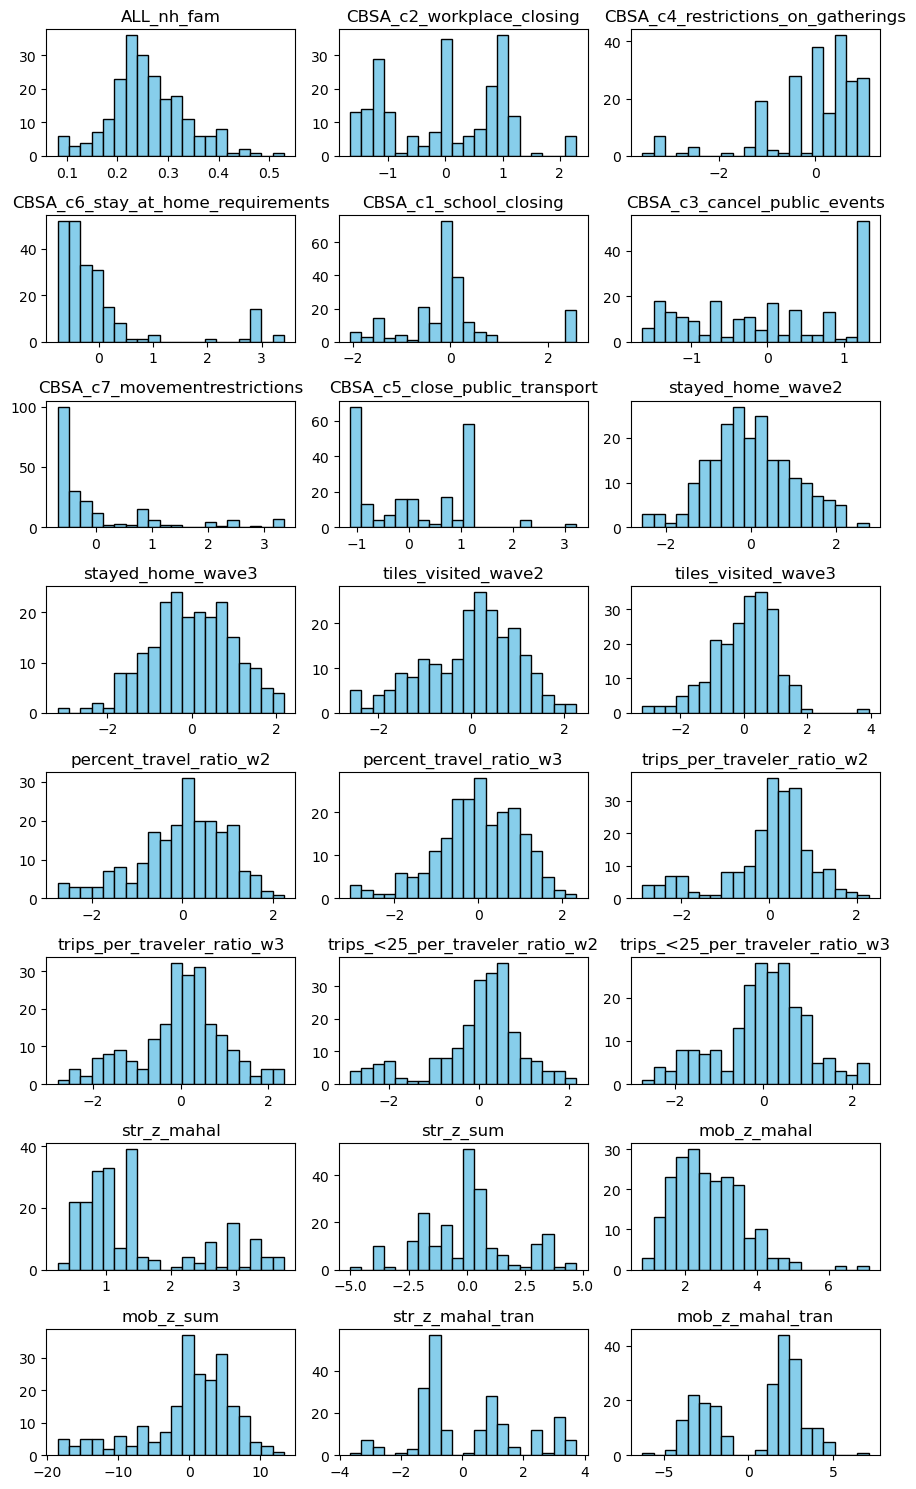

In [157]:
fig, axs = plt.subplots(8, 3, figsize=(9, 15)) # Change figsize as needed

for idx, col in enumerate(['ALL_nh_fam', 'CBSA_c2_workplace_closing', 'CBSA_c4_restrictions_on_gatherings',
       'CBSA_c6_stay_at_home_requirements',
       'CBSA_c1_school_closing', 'CBSA_c3_cancel_public_events',
       'CBSA_c7_movementrestrictions', 'CBSA_c5_close_public_transport',
       'stayed_home_wave2', 'stayed_home_wave3', 'tiles_visited_wave2',
       'tiles_visited_wave3', 'percent_travel_ratio_w2',
       'percent_travel_ratio_w3', 'trips_per_traveler_ratio_w2',
       'trips_per_traveler_ratio_w3', 'trips_<25_per_traveler_ratio_w2',
       'trips_<25_per_traveler_ratio_w3', 'str_z_mahal', 'str_z_sum',
       'mob_z_mahal', 'mob_z_sum',  'str_z_mahal_tran','mob_z_mahal_tran']):
    i = idx // 3
    j = idx % 3
    axs[i, j].hist(df_metrics_z[col], bins=20, color='skyblue', edgecolor='black')
    axs[i, j].set_title(col)

plt.tight_layout()